# Exercise Review: Distributed ML - WRANGLE
<a href="https://ds.codeup.com/distributed-ml/wrangle/#exercises">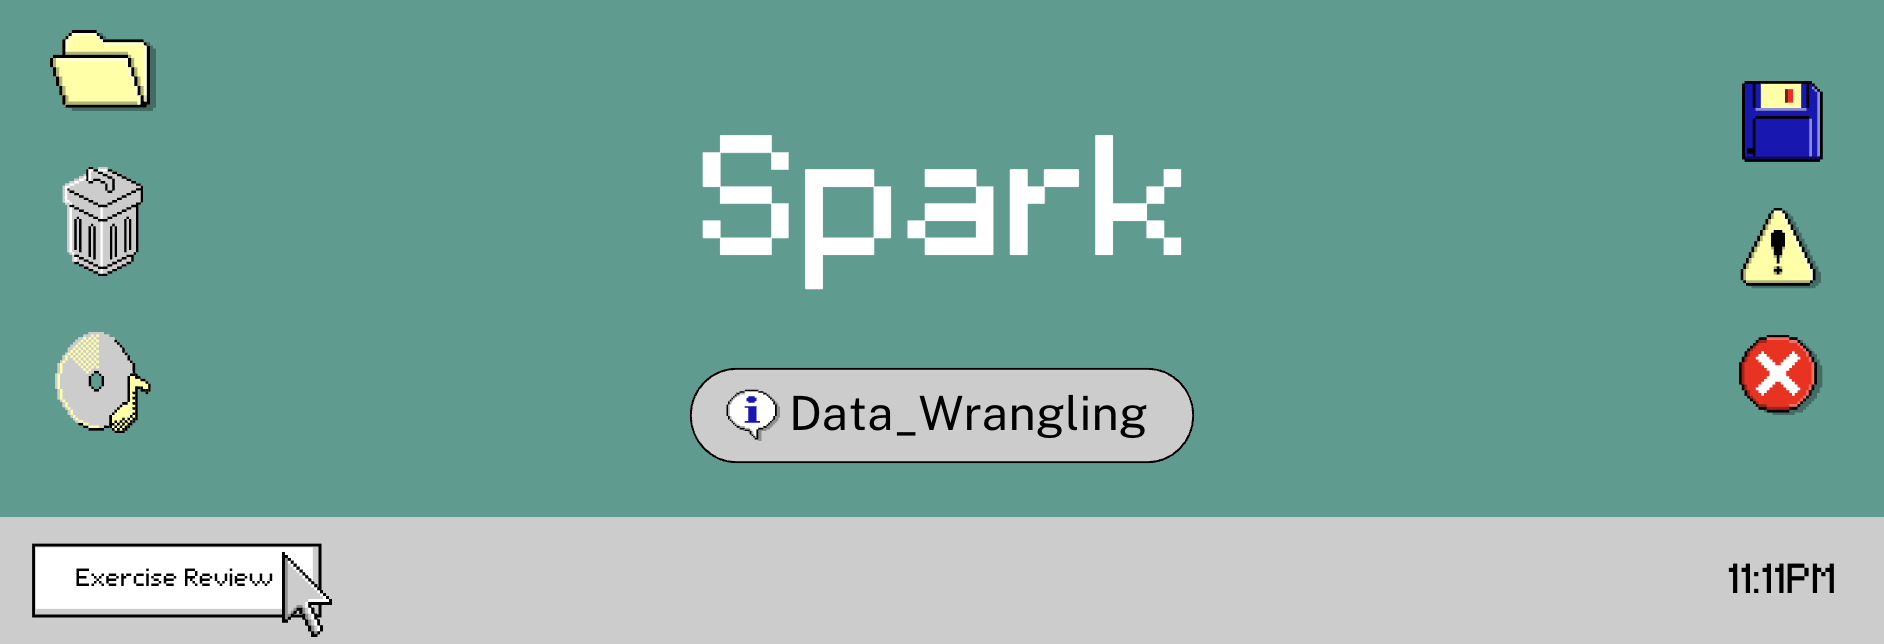</a>

<hr style="border:2px solid gray">

# Imports

In [1]:
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType
import pandas as pd


## Data Acquisition

These exercises should go in a notebook or script named `wrangle`. Add, commit, and push your changes.

This exercises use the `cases`, `dept`, and `source` tables from the `311_data` on the Codeup MySQL server.

---

You might have noticed that the latest date in the dataset is fairly far off from the present day. To account for this, replace any occurances of the current time with the maximum date from the dataset.

# DA1. Read the case, department, and source data into their own spark dataframes.

In [2]:
# Generate spark object to initialize a local Spark JVM process
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/05 16:18:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/07/05 16:18:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
case = spark.read.csv("case.csv", sep=',', header=True, inferSchema=True)
dept = spark.read.csv("dept.csv", sep=',', header=True, inferSchema=True)
source = spark.read.csv("source.csv", sep=',', header=True, inferSchema=True)

In [4]:
case.show(2,vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 1/1/18 0:42          
 case_closed_date     | 1/1/18 12:29         
 SLA_due_date         | 9/26/20 0:42         
 case_late            | NO                   
 num_days_late        | -998.5087616000001   
 case_closed          | YES                  
 dept_division        | Field Operations     
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 5                    
-RECORD 1------------------------------------
 case_id              | 1014127333           
 case_opened_date     | 1/1/18 0:46          
 case_closed_date     | 1/3/18 8:11          
 SLA_due_date         | 1/5/18 8:30          
 case_late            | NO                   
 num_days_late        | -2.0126041

In [5]:
case.columns

['case_id',
 'case_opened_date',
 'case_closed_date',
 'SLA_due_date',
 'case_late',
 'num_days_late',
 'case_closed',
 'dept_division',
 'service_request_type',
 'SLA_days',
 'case_status',
 'source_id',
 'request_address',
 'council_district']

# DA2. Let's see how writing to the local disk works in spark:

- Write the code necessary to store the source data in both csv and json
  format, store these as `sources_csv` and `sources_json`
- Inspect your folder structure. What do you notice?

In [6]:
source.show(2,vertical=True)

-RECORD 0---------------------------
 source_id       | 100137           
 source_username | Merlene Blodgett 
-RECORD 1---------------------------
 source_id       | 103582           
 source_username | Carmen Cura      
only showing top 2 rows



In [7]:
source.write.json("data/sources_json", mode="overwrite")

In [8]:
source.write.csv("data/sources_csv", header=True, mode="overwrite")

In [9]:
os.listdir("data")

['sources_csv', 'sources_json']

In [10]:
os.listdir("data/sources_csv")

['part-00000-28dad775-6210-4c65-8f5f-2cc3a16f755b-c000.csv',
 '._SUCCESS.crc',
 '.part-00000-28dad775-6210-4c65-8f5f-2cc3a16f755b-c000.csv.crc',
 '_SUCCESS']

In [11]:
os.listdir("data/sources_json")

['._SUCCESS.crc',
 'part-00000-3bb0e8c1-6fac-41fa-be3b-3eeda29e2faf-c000.json',
 '_SUCCESS',
 '.part-00000-3bb0e8c1-6fac-41fa-be3b-3eeda29e2faf-c000.json.crc']

<div class="alert alert-info" role="alert">

During the write operation, Spark writes the data files and their corresponding CRC files. 

The ".crc" files (Cyclic Redundancy Check), which have the ".crc" extension, are checksum files associated with the data files. They store checksum values computed for each corresponding data file. 
- These checksums are used by Spark to validate the integrity of the data during read operations and are not typically meant to be accessed or processed directly by users. 
    
Once all the data files and CRC files are successfully written, Spark creates the "_SUCCESS" file. This file is created as an indicator that the write operation completed successfully and that all the data files, including their associated CRC files, are valid.

</div>

# DA3. Inspect the data in your dataframes. Are the data types appropriate? Write the code necessary to cast the values to the appropriate types.

In [12]:
case.dtypes

[('case_id', 'int'),
 ('case_opened_date', 'string'),
 ('case_closed_date', 'string'),
 ('SLA_due_date', 'string'),
 ('case_late', 'string'),
 ('num_days_late', 'double'),
 ('case_closed', 'string'),
 ('dept_division', 'string'),
 ('service_request_type', 'string'),
 ('SLA_days', 'double'),
 ('case_status', 'string'),
 ('source_id', 'string'),
 ('request_address', 'string'),
 ('council_district', 'int')]

In [13]:
case.printSchema()

root
 |-- case_id: integer (nullable = true)
 |-- case_opened_date: string (nullable = true)
 |-- case_closed_date: string (nullable = true)
 |-- SLA_due_date: string (nullable = true)
 |-- case_late: string (nullable = true)
 |-- num_days_late: double (nullable = true)
 |-- case_closed: string (nullable = true)
 |-- dept_division: string (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: integer (nullable = true)



In [14]:
#rename col
case = case.withColumnRenamed("SLA_due_date", "case_due_date")

In [15]:
#convert data types

case = (
    case.withColumn("case_late", col("case_late")=="YES")
    .withColumn("case_closed", col("case_closed")=="YES")
)

case = case.withColumn("council_district", format_string("%03d", col("council_district")))

In [17]:
fmt = "M/d/yy H:mm" #saved to the underlying stored data

case = (
    case.withColumn('case_opened_date', to_timestamp(col('case_opened_date'), fmt))
    .withColumn('case_closed_date', to_timestamp(col('case_closed_date'), fmt))
    .withColumn('case_due_date', to_timestamp(col('case_due_date'), fmt))
)

In [18]:
# Cleanup text data
case = case.withColumn('request_address', lower(trim(col('request_address'))))

In [19]:
case.select("case_closed_date").sort(desc("case_closed_date")).first()

Row(case_closed_date=datetime.datetime(2018, 8, 8, 10, 38))

In [20]:
case.select(
    datediff(to_timestamp(lit("2018-08-08 10:38:00")), case.case_opened_date)
).show(3)

+-------------------------------------------------------------+
|datediff(to_timestamp(2018-08-08 10:38:00), case_opened_date)|
+-------------------------------------------------------------+
|                                                          219|
|                                                          219|
|                                                          219|
+-------------------------------------------------------------+
only showing top 3 rows



In [21]:
case.select(
    datediff(to_timestamp(current_timestamp()), case.case_opened_date)
).show(3)

+-------------------------------------------------------------+
|datediff(to_timestamp(current_timestamp()), case_opened_date)|
+-------------------------------------------------------------+
|                                                         2011|
|                                                         2011|
|                                                         2011|
+-------------------------------------------------------------+
only showing top 3 rows



In [22]:
# Extract zipcode
case = case.withColumn('zipcode', regexp_extract(col('request_address'), r'\d+$', 0))

# Create a `case_lifetime` feature
case = (
    case.withColumn('case_age', datediff(to_timestamp(lit('2018-08-08 10:38:00')), 'case_opened_date'))
    .withColumn('days_to_closed', datediff('case_closed_date', 'case_opened_date'))
    .withColumn('case_lifetime', when(
        col('case_closed'), col('days_to_closed')).otherwise(col('case_age')))
    .withColumn('curr_case_age', datediff(current_timestamp(), 'case_opened_date'))
    .drop('case_age', 'days_to_closed')
)

In [23]:
case.show(2, vertical=True, truncate=False)

-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 dept_division        | Field Operations                     
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  el paso st, san antonio, 78207 
 council_district     | 005                                  
 zipcode              | 78207                                
 case_li

---
# Exercises

# 1. How old is the latest (in terms of days past SLA) currently open issue? How long has the oldest (in terms of days since opened) currently opened issue been open?

In [24]:
case.filter("! case_closed")\
    .select('case_id', 'case_lifetime', 'case_opened_date', 'case_closed_date', 'num_days_late')\
    .sort(desc("num_days_late")).show(5)

+----------+-------------+-------------------+----------------+------------------+
|   case_id|case_lifetime|   case_opened_date|case_closed_date|     num_days_late|
+----------+-------------+-------------------+----------------+------------------+
|1013225646|          584|2017-01-01 13:48:00|            null|       348.6458333|
|1013225651|          584|2017-01-01 13:57:00|            null|       348.6458333|
|1013226813|          583|2017-01-02 11:26:00|            null|348.52356480000003|
|1013229328|          582|2017-01-03 10:01:00|            null|347.58256939999995|
|1013236238|          580|2017-01-05 14:39:00|            null|       345.3894213|
+----------+-------------+-------------------+----------------+------------------+
only showing top 5 rows



In [25]:
case.filter("! case_closed")\
    .select('case_id', 'case_lifetime', 'curr_case_age', 'case_opened_date', 'case_closed_date', 'num_days_late')\
    .sort(desc("num_days_late")).show(5)

+----------+-------------+-------------+-------------------+----------------+------------------+
|   case_id|case_lifetime|curr_case_age|   case_opened_date|case_closed_date|     num_days_late|
+----------+-------------+-------------+-------------------+----------------+------------------+
|1013225646|          584|         2376|2017-01-01 13:48:00|            null|       348.6458333|
|1013225651|          584|         2376|2017-01-01 13:57:00|            null|       348.6458333|
|1013226813|          583|         2375|2017-01-02 11:26:00|            null|348.52356480000003|
|1013229328|          582|         2374|2017-01-03 10:01:00|            null|347.58256939999995|
|1013236238|          580|         2372|2017-01-05 14:39:00|            null|       345.3894213|
+----------+-------------+-------------+-------------------+----------------+------------------+
only showing top 5 rows



# 2. How many Stray Animal cases are there?

In [26]:
case.groupby("service_request_type").count().sort(desc("count")).show(truncate=False)

+---------------------------------+-----+
|service_request_type             |count|
+---------------------------------+-----+
|No Pickup                        |86855|
|Overgrown Yard/Trash             |65895|
|Bandit Signs                     |32910|
|Damaged Cart                     |30338|
|Front Or Side Yard Parking       |28794|
|Stray Animal                     |26760|
|Aggressive Animal(Non-Critical)  |24882|
|Cart Exchange Request            |22024|
|Junk Vehicle On Private Property |21473|
|Pot Hole Repair                  |20616|
|Alley-Way Maintenance            |20214|
|Lost/Stolen Cart                 |18731|
|Right Of Way/Sidewalk Obstruction|17699|
|Dead Animal - Dog                |16714|
|Cart Delivery                    |15471|
|Dead Animal - Cat                |14983|
|Animal Neglect                   |13441|
|Dead Animal - Misc               |13234|
|Trapped/Confined Animal          |11354|
|Public Nuisance(Own Animal)      |10715|
+---------------------------------

In [27]:
case.filter(case.service_request_type == lit("Stray Animal")).count()

26760

# 3. How many service requests that are assigned to the Field Operations department (`dept_division`) are not classified as "Officer Standby" request type (`service_request_type`)?

In [28]:
case.filter(case.dept_division == "Field Operations").filter(case.service_request_type != "Officer Standby").count()

113902

# 4. Convert the `council_district` column to a string column.

In [29]:
case = case.withColumn('council_district', col('council_district').cast('string'))

# 5. Extract the year from the `case_closed_date` column.

In [30]:
case.withColumn("year", year("case_closed_date")).select("service_request_type", 'case_closed_date', 'year')\
.show(5)

+--------------------+-------------------+----+
|service_request_type|   case_closed_date|year|
+--------------------+-------------------+----+
|        Stray Animal|2018-01-01 12:29:00|2018|
|Removal Of Obstru...|2018-01-03 08:11:00|2018|
|Removal Of Obstru...|2018-01-02 07:57:00|2018|
|Front Or Side Yar...|2018-01-02 08:13:00|2018|
|Animal Cruelty(Cr...|2018-01-01 13:29:00|2018|
+--------------------+-------------------+----+
only showing top 5 rows



# 6. Convert `num_days_late` from days to hours in new columns `num_hours_late`.

In [31]:
case.withColumn("num_hours_late", round(expr("num_days_late * 24"), 1))\
.select("num_days_late", 'num_hours_late').show(5)

+-------------------+--------------+
|      num_days_late|num_hours_late|
+-------------------+--------------+
| -998.5087616000001|      -23964.2|
|-2.0126041669999997|         -48.3|
|       -3.022337963|         -72.5|
|       -15.01148148|        -360.3|
|0.37216435200000003|           8.9|
+-------------------+--------------+
only showing top 5 rows



# 7. Join the case data with the source and department data.

In [32]:
df = case.join(source, "source_id", "left").drop(source.source_id)

df.show(2, vertical=True)

-RECORD 0------------------------------------
 source_id            | svcCRMLS             
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 dept_division        | Field Operations     
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 request_address      | 2315  el paso st,... 
 council_district     | 005                  
 zipcode              | 78207                
 case_lifetime        | 0                    
 curr_case_age        | 2011                 
 source_username      | svcCRMLS             
-RECORD 1------------------------------------
 source_id            | svcCRMSS             
 case_id              | 1014127333

In [33]:
df = df.join(dept, "dept_division", "left")\
    .drop(dept.dept_division)\
    .drop(dept.dept_name)\
    .withColumnRenamed('standardized_dept_name', 'department')\
    .withColumn('dept_subject_to_SLA', col('dept_subject_to_SLA') == 'YES')
df.show(2, vertical=True)

-RECORD 0------------------------------------
 dept_division        | Field Operations     
 source_id            | svcCRMLS             
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 request_address      | 2315  el paso st,... 
 council_district     | 005                  
 zipcode              | 78207                
 case_lifetime        | 0                    
 curr_case_age        | 2011                 
 source_username      | svcCRMLS             
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
-RECORD 1-------------------------

# 8. Are there any cases that do not have a request source?

In [34]:
df.filter(df.source_id == "null").count()

0

In [35]:
df.filter(df.source_id == "").count()

0

# 9. What are the top 10 service request types in terms of number of requests?

In [37]:
df.groupby("service_request_type").count().sort(desc("count")).show(10, 50)

+--------------------------------+-----+
|            service_request_type|count|
+--------------------------------+-----+
|                       No Pickup|89210|
|            Overgrown Yard/Trash|66403|
|                    Bandit Signs|32968|
|                    Damaged Cart|31163|
|      Front Or Side Yard Parking|28920|
|                    Stray Animal|27361|
| Aggressive Animal(Non-Critical)|25492|
|           Cart Exchange Request|22608|
|Junk Vehicle On Private Property|21649|
|                 Pot Hole Repair|20827|
+--------------------------------+-----+
only showing top 10 rows



# 10. What are the top 10 service request types in terms of average days late?

In [39]:
df.groupby("service_request_type").agg(round(mean("num_days_late"), 1).alias("avg_late"))\
.sort(desc("avg_late")).show(10, 50)

+--------------------------------------+--------+
|                  service_request_type|avg_late|
+--------------------------------------+--------+
|                    Zoning: Junk Yards|   176.0|
|            Labeling for Used Mattress|   162.4|
|     Record Keeping of Used Mattresses|   154.0|
|Signage Requied for Sale of Used Mattr|   151.6|
|              Storage of Used Mattress|   142.1|
|                  Zoning: Recycle Yard|   135.9|
|        Donation Container Enforcement|   131.8|
|   License Requied Used Mattress Sales|   128.8|
|               Traffic Signal Graffiti|   101.8|
|                             Complaint|    72.9|
+--------------------------------------+--------+
only showing top 10 rows



# 11. Does number of days late depend on department?

In [40]:
df.groupby("department").agg(round(mean("num_days_late"), 1). alias("avg_late"))\
.sort(desc("avg_late")).show(10, 50)

+------------------------+--------+
|              department|avg_late|
+------------------------+--------+
|        Customer Service|    59.7|
|             Solid Waste|    -2.2|
|            Metro Health|    -4.9|
|      Parks & Recreation|    -5.3|
|Trans & Cap Improvements|   -20.6|
|    DSD/Code Enforcement|   -38.4|
|    Animal Care Services|  -226.5|
|            City Council|    null|
+------------------------+--------+



# 12. How do number of days late depend on department and request type?

In [43]:
df.groupby("department", "service_request_type")\
.agg(round(avg("num_days_late"), 1).alias("avg_days_late")).sort("department").show(50,50)

+--------------------+----------------------------------------+-------------+
|          department|                    service_request_type|avg_days_late|
+--------------------+----------------------------------------+-------------+
|Animal Care Services|                Injured Animal(Critical)|         -0.1|
|Animal Care Services|             Aggressive Animal(Critical)|         16.7|
|Animal Care Services|                   Animal Bite(Critical)|          0.0|
|Animal Care Services|                 Trapped/Confined Animal|          0.2|
|Animal Care Services|             City Council Animal Request|         -1.5|
|Animal Care Services|         Aggressive Animal(Non-Critical)|          2.6|
|Animal Care Services|                            Stray Animal|       -998.8|
|Animal Care Services|                Animal Cruelty(Critical)|         -0.1|
|Animal Care Services|             Public Nuisance(Own Animal)|         -2.2|
|Animal Care Services|                          Animal Neglect| 